# The full training pipeline

In this second block, consisting again of multiple notebooks, we'll take a look at the full pipeline of graph neural networks, from a cleanly described thing (a graph representation of molecules) to training a neural network.

Since the goal is to give you an actual understanding of the inner workings of GNNs, we will not use *PyTorch Geometric*. While the latter is a very commonly used package in practice (and we do recommend using it), it hides some of the details we'd like to bring across.

In this first notebook we'll go over the full pipeline from raw data to a trained GNN without going into detailed explanations (don't worry, those will come later). The idea is for you to first get an overview of which pieces need to be in place for the GNN to run.

**Try to get an understanding of the structure of this code, we'll cover the details in the next notebook**

## List of contents

This notebook covers the following steps

- Preamble: Installing packages / dependencies (copied from block 1)
- Graph representations from raw data (copied from block 1)
- Writing a dataset class for graphs
- Modifying the pytorch data loaders to fit graph datasets
- The actual dataset: load, split & build
- Implementing the GNN
- Training the model
- Getting predictions


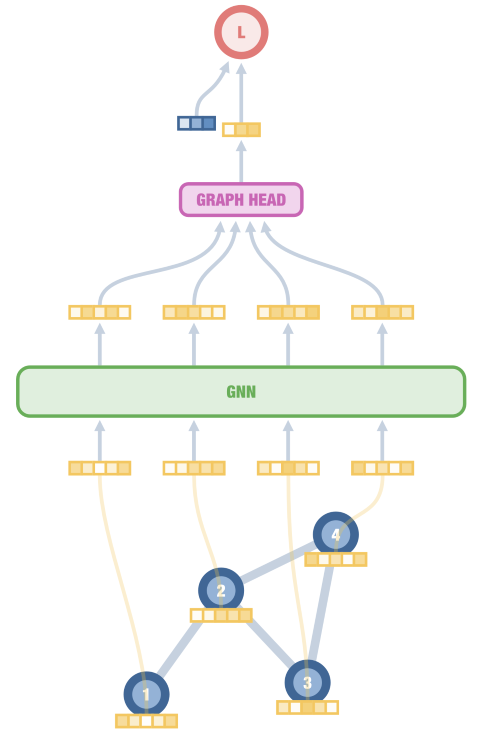

# Preamble: Installing packages / dependencies
Before we can start with the notebook, we'll install condacolab and the packages required by the notebook


**Important:**

**Before running the first cell, make sure you are using an accelerated environment (in the menu, go to Runtime -> Change runtime type and select 'GPU' under accelerator).**

In [1]:
# Install a Mamba (~Conda) environment on your Colab VM.
# NOTE: You will likely get a notification about your session crashing in the
# bottom left corner of the window. This is expected behavior as the install
# will restart the python kernel. Wait until this cell is done before running
# the rest of the notebook.

# You may have to run this cell twice for everything to work.

!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
# Check that we now have a working conda environment.
# You should get the output "Everything looks OK!"

import condacolab
condacolab.check()

# Check what cuda version is installed
# This should ideally match the cudatoolkit=X we give to the mamba install line
print()
!nvcc --version 

import sys
print('\nsys version:\n{}'.format(sys.version))

✨🍰✨ Everything looks OK!

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0

sys version:
3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [3]:
# Install the required package (RDKit). This can take a minute or ten.
!mamba install pytorch cudatoolkit=11.1 rdkit -c pytorch -c conda-forge > /dev/null
print("Done installing packages")

Done installing packages


# The Graph Data

First, we'll re-instantiate the functions and classes introduced in the first block. Remember, these will let us go from raw data to complete representations of the graph.


In [4]:
import rdkit
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

IPythonConsole.ipython_useSVG = True # < use SVGs instead of PNGs
IPythonConsole.drawOptions.addAtomIndices = True # adding indices
IPythonConsole.molSize = 300, 300

import torch
from torch.utils.data import Dataset, DataLoader
from collections.abc import Set

float_type = torch.float32  # Hardcoding datatypes for tensors
categorical_type = torch.long
mask_type = torch.float32  # Hardcoding datatype for masks
labels_type = torch.float32 # Hardcoding datatype for labels

class ContinuousFeature:
  def __init__(self, name):
    self.name = name

  def __repr__(self):
    return f'<ContinuousFeature: {self.name}>'

  def __eq__(self, other): # Q to Erik: can we leave this out?
    return self.name == other.name

  def __hash__(self):
    return hash(self.name)


class CategoricalFeature:
  def __init__(self, name, values, add_null_value=True):
    self.name = name
    self.has_null_value = add_null_value
    if self.has_null_value:
      self.null_value = None
      values = (None,) + tuple(values)
    self.values = tuple(values)
    self.value_to_idx_mapping = {v: i for i, v in enumerate(values)}
    self.inv_value_to_idx_mapping = {i: v for v, i in
                                     self.value_to_idx_mapping.items()}
    
    if self.has_null_value:
      self.null_value_idx = self.value_to_idx_mapping[self.null_value]
  
  def get_null_idx(self): # Q to Erik: can we leave this out?
    if self.has_null_value:
      return self.null_value_idx
    else:
      raise RuntimeError(f"Categorical variable {self.name} has no null value")

  def value_to_idx(self, value):
    return self.value_to_idx_mapping[value]
  
  def idx_to_value(self, idx):
    return self.inv_value_to_idx_mapping[idx]
  
  def __len__(self):
    return len(self.values)
  
  def __repr__(self):
    return f'<CategoricalFeature: {self.name}>'

  def __eq__(self, other): # Q to Erik: can we leave this out?
    return self.name == other.name and self.values == other.values

  def __hash__(self):
    return hash((self.name, self.values))


# Atom types
ATOM_SYMBOLS = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
                'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 
                'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 
                'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 
                'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
                'Ba', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 
                'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Rf', 'Db', 'Sg', 
                'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Fl', 'Lv', 'La', 'Ce',
                'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er',
                'Tm', 'Yb', 'Lu', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm',
                'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']
SYMBOLS_FEATURE = CategoricalFeature('atom_symbol', ATOM_SYMBOLS)

# Aromaticity
AROMATIC_VALUES = [True, False]
AROMATIC_FEATURE = CategoricalFeature('is_aromatic', AROMATIC_VALUES)

# Explicit valance
EXPLICIT_VALANCE_FEATURE = ContinuousFeature('explicit_valance')

# Implicit valance
IMPLICIT_VALANCE_FEATURE = ContinuousFeature('implicit_valance')

# Combine all four into one list of features
ATOM_FEATURES = [SYMBOLS_FEATURE,
                 AROMATIC_FEATURE,
                 EXPLICIT_VALANCE_FEATURE,
                 IMPLICIT_VALANCE_FEATURE]

# Bond types
BOND_TYPES = ['UNSPECIFIED', 'SINGLE', 'DOUBLE', 'TRIPLE', 'QUADRUPLE', 
              'QUINTUPLE', 'HEXTUPLE', 'ONEANDAHALF', 'TWOANDAHALF',
              'THREEANDAHALF','FOURANDAHALF', 'FIVEANDAHALF', 'AROMATIC', 
              'IONIC', 'HYDROGEN', 'THREECENTER',	'DATIVEONE', 'DATIVE',
              'DATIVEL', 'DATIVER', 'OTHER', 'ZERO']
TYPE_FEATURE = CategoricalFeature('bond_type', BOND_TYPES)

# Bond directions
BOND_DIRECTIONS = ['NONE', 'BEGINWEDGE', 'BEGINDASH', 'ENDDOWNRIGHT',
                   'ENDUPRIGHT', 'EITHERDOUBLE' ]
DIRECTION_FEATURE = CategoricalFeature('bond_direction', BOND_DIRECTIONS)

# Bond, James Bond
BOND_STEREO = ['STEREONONE', 'STEREOANY', 'STEREOZ', 'STEREOE', 
               'STEREOCIS', 'STEREOTRANS']
STEREO_FEATURE = CategoricalFeature('bond_stereo', BOND_STEREO)

# Aromaticity
AROMATIC_VALUES = [True, False]
AROMATIC_FEATURE = CategoricalFeature('is_aromatic', AROMATIC_VALUES)

# Combine all four into one list of features
BOND_FEATURES = [TYPE_FEATURE,
                 DIRECTION_FEATURE,
                 AROMATIC_FEATURE,
                 STEREO_FEATURE]

# Atom features
def get_atom_features(rd_atom):
  atom_symbol = rd_atom.GetSymbol()
  is_aromatic = rd_atom.GetIsAromatic()
  implicit_valance = float(rd_atom.GetImplicitValence())
  explicit_valance = float(rd_atom.GetExplicitValence())
  return {SYMBOLS_FEATURE: atom_symbol,
          AROMATIC_FEATURE: is_aromatic,
          EXPLICIT_VALANCE_FEATURE: explicit_valance,
          IMPLICIT_VALANCE_FEATURE: implicit_valance}

# Bond features
def get_bond_features(rd_bond):
  bond_type = str(rd_bond.GetBondType())
  bond_stereo_info = str(rd_bond.GetStereo())
  bond_direction = str(rd_bond.GetBondDir())
  is_aromatic = rd_bond.GetIsAromatic()
  return {TYPE_FEATURE: bond_type,
          DIRECTION_FEATURE: bond_direction,
          AROMATIC_FEATURE: is_aromatic,
          STEREO_FEATURE: bond_stereo_info}

# Create dictionaries of the atoms and bonds in a molecule
def rdmol_to_graph(rd_mol):
  atoms = {rd_atom.GetIdx(): get_atom_features(rd_atom)
           for rd_atom in rd_mol.GetAtoms()}
  bonds = {frozenset((rd_bond.GetBeginAtomIdx(), rd_bond.GetEndAtomIdx())):
           get_bond_features(rd_bond) for rd_bond in rd_mol.GetBonds()}        
  return atoms, bonds

def smiles_to_graph(smiles):
  rd_mol = MolFromSmiles(smiles)
  graph = rdmol_to_graph(rd_mol)
  return graph

# The Dataset class

We will now create a dataset class. The main functions of this class are to accumulate the entire dataset in a single object instead of multiple lists (graphs, labels, variables), to translate the provided representations into tensors, and to return individual samples on request.

This dataset class follows python's iterator protocols, which allows pytorch's dataloader to use it, i.e., request individual samples from it to create batches from them.

The most important functions within the class are $__init__()$ which shows you what's going in when we create it, and $__getitem__()$ which shows you how the output (a single graph representation in tensor format) is constructed from it.

At this point, it's ok to just run the cell without reading the code.

In [5]:
class GraphDataset(Dataset):

  def __init__(self, *, graphs, labels, node_variables, edge_variables,
               metadata=None):
    '''
    Create a new graph dataset, 
    '''

    assert len(graphs) == len(labels), \
      "The graphs and labels lists must be the same length"
    if metadata is not None:
      assert len(metadata) == len(graphs),\
        "The metadata list needs to be as long as the graphs"

    self.graphs = graphs
    self.labels = labels
    self.metadata = metadata
    self.node_variables = node_variables
    self.edge_variables = edge_variables
    self.categorical_node_variables = [var for var in self.node_variables
                                       if isinstance(var, CategoricalFeature)]
    self.continuous_node_variables = [var for var in self.node_variables
                                      if isinstance(var, ContinuousFeature)]
    self.categorical_edge_variables = [var for var in self.edge_variables
                                       if isinstance(var, CategoricalFeature)]
    self.continuous_edge_variables = [var for var in self.edge_variables
                                      if isinstance(var, ContinuousFeature)]

  def __len__(self):

    return len(self.graphs)

  def make_continuous_node_features(self, nodes):

    if len(self.continuous_node_variables) == 0:
      return None

    n_nodes = len(nodes)
    n_features = len(self.continuous_node_variables)
    continuous_node_features = torch.zeros((n_nodes, n_features),
                                           dtype=float_type)
    for node_idx, features in nodes.items():
      node_features = torch.tensor([features[continuous_feature]
                                    for continuous_feature
                                    in self.continuous_node_variables],
                                   dtype=float_type)
      continuous_node_features[node_idx] = node_features
    return continuous_node_features
      
  def make_categorical_node_features(self, nodes):

    if len(self.categorical_node_variables) == 0:
      return None
    n_nodes = len(nodes)
    n_features = len(self.categorical_node_variables)
    categorical_node_features = torch.zeros((n_nodes, n_features),
                                            dtype=categorical_type)

    for node_idx, features in nodes.items():
      for i, categorical_variable in enumerate(self.categorical_node_variables):
          value = features[categorical_variable]
          value_index = categorical_variable.value_to_idx(value)
          categorical_node_features[node_idx, i] = value_index

    return categorical_node_features

  def make_continuous_edge_features(self, n_nodes, edges):

    if len(self.continuous_edge_variables) == 0:
      return None
    n_features = len(self.continuous_edge_variables)
    continuous_edge_features = torch.zeros((n_nodes, n_nodes, n_features),
                                           dtype=float_type)
    for edge, features in edges.items():
      edge_features = torch.tensor([features[continuous_feature]
                                    for continuous_feature in
                                    self.continuous_edge_variables],
                                   dtype=float_type)
      u,v = edge
      continuous_edge_features[u, v] = edge_features
      if isinstance(edge, Set):
        continuous_edge_features[v, u] = edge_features

    return continuous_edge_features

  def make_categorical_edge_features(self, n_nodes, edges):

    if len(self.categorical_edge_variables) == 0:
      return None
    n_features = len(self.categorical_edge_variables)
    categorical_edge_features = torch.zeros((n_nodes, n_nodes, n_features),
                                            dtype=categorical_type)

    for edge, features in edges.items():
      u,v = edge
      for i, categorical_variable in enumerate(self.categorical_edge_variables):
          value = features[categorical_variable]
          value_index = categorical_variable.value_to_idx(value)
          categorical_edge_features[u, v, i] = value_index
          if isinstance(edge, Set):
            categorical_edge_features[v, u, i] = value_index

    return categorical_edge_features
  
  def __getitem__(self, index):

    graph = self.graphs[index]
    nodes, edges = graph
    n_nodes = len(nodes)
    continuous_node_features = self.make_continuous_node_features(nodes)
    categorical_node_features = self.make_categorical_node_features(nodes)
    continuous_edge_features = self.make_continuous_edge_features(n_nodes,
                                                                  edges)
    categorical_edge_features = self.make_categorical_edge_features(n_nodes,
                                                                    edges)
    
    label = self.labels[index]

    nodes_idx = sorted(nodes.keys())
    edge_list = sorted(edges.keys())

    n_nodes = len(nodes)
    adjacency_matrix = torch.zeros((n_nodes, n_nodes), dtype=float_type)
    for edge in edges:
      u, v = edge
      adjacency_matrix[u,v] = 1
      if isinstance(edge, Set):
        # This edge is unordered, assume this is a undirected graph
        adjacency_matrix[v,u] = 1

    data_record = {'nodes': nodes_idx,
                   'adjacency_matrix': adjacency_matrix,
                   'categorical_node_features': categorical_node_features,
                   'continuous_node_features': continuous_node_features,
                   'categorical_edge_features': categorical_edge_features,
                   'continuous_edge_features': continuous_edge_features,
                   'label': label}

    if self.metadata is not None:
      data_record['metadata'] = self.metadata[index]

    return data_record

  def get_node_variables(self):
    return {'continuous': self.continuous_node_variables,
            'categorical': self.categorical_node_variables}
  
  def get_edge_variables(self):
    return {'continuous': self.continuous_edge_variables,
            'categorical': self.categorical_edge_variables}

# The DataLoader

Next up is the dataloader, and we will simply use pytorch's implementation. However, we need to define how to accumulate the individual samples returned by the dataset in batches. This is necessary, as the molecules in our dataset have varying numbers of atoms in them, and thus the graphs are of different size.

To define how the individual samples are accumulated, we simply replace the collate function of pytorch's dataloader. In the following, we will define the new collate function, while the actual instantiation of the dataloader (with the function replacement) will follow further down.

For now, it's ok to just run this cell, and not read it in detail.

In [6]:
from collections.abc import Set

def collate_graph_batch(batch):

  '''Collate a batch of graph dictionaries produdce by a GraphDataset'''
  
  batch_size = len(batch)
  max_nodes = max(len(graph['nodes']) for graph in batch)
  
  adjacency_matrices = torch.zeros((batch_size, max_nodes, max_nodes),
                                   dtype=float_type)
  labels = torch.tensor([graph['label'] for graph in batch], dtype=labels_type)
  stacked_continuous_node_features = None
  stacked_categorical_node_features = None
  stacked_continuous_edge_features = None
  stacked_categorical_edge_features = None

  nodes_mask = torch.zeros((batch_size, max_nodes), dtype=mask_type)
  edge_mask = torch.zeros((batch_size, max_nodes, max_nodes), dtype=mask_type)
  
  has_metadata = False

  for i, graph in enumerate(batch):
    if 'metadata' in graph:
      has_metadata = True
      
    adjacency_matrix = graph['adjacency_matrix']
    g_nodes, g_nodes = adjacency_matrix.shape
    adjacency_matrices[i, :g_nodes, :g_nodes] = adjacency_matrix

    edge_mask[i, :g_nodes, :g_nodes] = 1
    nodes_mask[i, :g_nodes] = 1
    
    g_continuous_node_features = graph['continuous_node_features']
    if g_continuous_node_features is not None:
      if stacked_continuous_node_features is None:
        g_nodes, num_features = g_continuous_node_features.shape
        stacked_continuous_node_features = torch.zeros((batch_size, max_nodes,
                                                        num_features))
      stacked_continuous_node_features[i, :g_nodes] = g_continuous_node_features
    
    g_categorical_node_features = graph['categorical_node_features']
    if g_categorical_node_features is not None:
      if stacked_categorical_node_features is None:
        g_nodes, num_features = g_categorical_node_features.shape
        stacked_categorical_node_features = torch.zeros((batch_size, max_nodes,
                                                         num_features),
                                                        dtype=categorical_type)
      stacked_categorical_node_features[i, :g_nodes] =\
        g_categorical_node_features

    g_continuous_edge_features = graph['continuous_edge_features']
    if g_continuous_edge_features is not None:
      if stacked_continuous_edge_features is None:
        g_nodes, g_nodes, num_features = g_continuous_edge_features.shape
        stacked_continuous_edge_features = torch.zeros((batch_size, max_nodes,
                                                        max_nodes,
                                                        num_features))
      stacked_continuous_edge_features[i, :g_nodes, :g_nodes] =\
        g_continuous_edge_features

    g_categorical_edge_features = graph['categorical_edge_features']
    if g_categorical_edge_features is not None:
      if stacked_categorical_edge_features is None:
        g_nodes, g_nodes, num_features = g_categorical_edge_features.shape
        stacked_categorical_edge_features = torch.zeros((batch_size, max_nodes,
                                                         max_nodes,
                                                         num_features),
                                                        dtype=categorical_type)
      stacked_categorical_edge_features[i, :g_nodes, :g_nodes] =\
        g_categorical_edge_features

  batch_record = {'adjacency_matrices': adjacency_matrices,
          'categorical_node_features': stacked_categorical_node_features,
          'continuous_node_features': stacked_continuous_node_features,
          'categorical_edge_features': stacked_categorical_edge_features,
          'continuous_edge_features': stacked_continuous_edge_features,
          'nodes_mask': nodes_mask,
          'edge_mask': edge_mask,
          'labels': labels}

  if has_metadata:
    batch_record['metadata'] = [g['metadata'] for g in batch]

  return batch_record


# Experiment dataset
To illustrate training a neural network on graphs, we'll use a molecular property prediction task. This is commonly used as a way of screening molecules _in silico_ for properties of candidate molecules in drug development. The task we'll look at is called _Blood Brain Barrier Penetration_, and we'll use a dataset from the MoleculeNet benchmark suite (https://moleculenet.org) originally assembled by Martins et. al. [Martins, I. F.; Teixeira, A. L.; Pinheiro, L.; Falcao, A. O. Journal of Chemical Information and Modeling 2012, 52, 1686–1697]

## Blood Brain Barrier Penetration
An important property to look at for molecules in drug development is whether they can pass through the membrane seperating the blood stream from the  brain extracellular fluid. This barrier blocks many molecules and for drugs which have the purpose of targeting the central nervous system it's important to find those which can pass through the barrier. For drugs which should not penetrate the barrier it's important to make sure they do not.

In [7]:
# Well start by downloading the dataset.
# We're relying on the direct download link from MoleculeNet
! wget -q https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv

In [8]:
import pandas as pd
bbbp_table = pd.read_csv('BBBP.csv')
bbbp_table

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...
...,...,...,...,...
2045,2049,licostinel,1,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl
2046,2050,ademetionine(adenosyl-methionine),1,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...
2047,2051,mesocarb,1,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...
2048,2052,tofisoline,1,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...


The dataset is in a simple CSV. The columns we want to use is 'smiles' and 'p_np'. Many datasets like this unfortunately contain malformed smiles (the chemistry of the SMILES isn't valid because some fragments might have been removed during pre-processing). In this dataset it's relatively few, and we'll filter the dataset while we're doing the splitting. RDKit will tell us when molecules are invalid by returning `None` from the `MolFromSmiles` function.

## Data splitting

In this example we will randomly split the dataset. This is the default way for many datasets and tasks in deep learning, and the ways of splitting a dataset are not at the focus of this workshop. However, there are cases where completely random splitting of the dataset is not the prefered choice, and this is one of these cases. In short, if the dataset contains samples from various classes of varying sizes, one might want to make sure that even the smaller classes are contained in both training and validation / testing. For the more advanced _scaffold split_ strategy recommended for the MoleculeNet benchmark, you can look at the notebook `_GNN_02A-appendix_scaffold_splitting.ipynb`.


In [9]:
# There are about 50 problematic SMILES, RDKit will give you about as many
# ERRORs and WARNINGs, this is expected behaviour. We supress the WARNINGS.
# 11 of the SMILES can't be parsed at all
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  

smiles_records = []
for i, num, name, p_np, smiles in bbbp_table.to_records():
  # check if RDKit accepts this smiles
  if MolFromSmiles(smiles) is not None:
    smiles_record = {'smiles': smiles, 'label': p_np, 'metadata': {'row': i}}
    smiles_records.append(smiles_record)
  else:
    print(f'Molecule {smiles} on row {i} could not be parsed by RDKit')
  

Molecule O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3 on row 59 could not be parsed by RDKit
Molecule c1(nc(NC(N)=[NH2])sc1)CSCCNC(=[NH]C#N)NC on row 61 could not be parsed by RDKit
Molecule Cc1nc(sc1)\[NH]=C(\N)N on row 391 could not be parsed by RDKit
Molecule s1cc(CSCCN\C(NC)=[NH]\C#N)nc1\[NH]=C(\N)N on row 614 could not be parsed by RDKit
Molecule c1c(c(ncc1)CSCCN\C(=[NH]\C#N)NCC)Br on row 642 could not be parsed by RDKit
Molecule n1c(csc1\[NH]=C(\N)N)c1ccccc1 on row 645 could not be parsed by RDKit
Molecule n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N on row 646 could not be parsed by RDKit
Molecule n1c(csc1\[NH]=C(\N)N)c1cccc(c1)NC(C)=O on row 647 could not be parsed by RDKit
Molecule n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N\C(NC)=[NH]\C#N on row 648 could not be parsed by RDKit
Molecule s1cc(nc1\[NH]=C(\N)N)C on row 649 could not be parsed by RDKit
Molecule c1(cc(N\C(=[NH]\c2cccc(c2)CC)C)ccc1)CC on row 685 could not be parsed by RDKit


Next up, we define a number of parameters relevant to splitting the data, and then do the actual split into a training and a development set.

In [10]:
import random
random.seed(1729)

training_fraction = 0.8
dev_fraction = 0.1
n_examples = len(smiles_records)
n_training_examples = int(n_examples*training_fraction)
n_dev_examples = int(n_examples*dev_fraction)

indices = list(range(n_examples))
random.shuffle(indices)  # shuffle is in place
training_indices = indices[:n_training_examples]
dev_indices = indices[n_training_examples:n_training_examples+n_dev_examples]
test_indices = indices[n_training_examples+n_dev_examples:]

training_smiles_records = [smiles_records[i] for i in training_indices]
dev_smiles_records = [smiles_records[i] for i in dev_indices]
test_smiles_records = [smiles_records[i] for i in test_indices]

## Building the datasets

We now have all the information needed to build our dataset splits. We'll create the graphs from the smiles of these recrords, but also save the original smiles and row in the bbbp_table dataset if we are interested in going back from a specific graph and see where it comes from (e.g. figure out if a missprediction can be explained by domain knowledge).

In [11]:
def make_molecular_graph_dataset(smiles_records, atom_features=ATOM_FEATURES,
                                 bond_features=BOND_FEATURES):
  
  '''
  Create a new GraphDataset from a list of smiles_records dictionaries.
  These records should contain the key 'smiles' and 'label'. Any other keys
  will be saved as a 'metadata' record.
  '''

  graphs = []
  labels = []
  metadata = []
  for smiles_record in smiles_records:
    smiles = smiles_record['smiles']
    label = smiles_record['label']
    graph = smiles_to_graph(smiles)
    graphs.append(graph)
    labels.append(label)
    metadata.append(smiles_record)

  return GraphDataset(graphs=graphs, 
                      labels=labels, 
                      node_variables=atom_features, 
                      edge_variables=bond_features, 
                      metadata=metadata)
  
  
training_graph_dataset = make_molecular_graph_dataset(training_smiles_records)
dev_graph_dataset = make_molecular_graph_dataset(dev_smiles_records)
test_graph_dataset = make_molecular_graph_dataset(test_smiles_records)

We now have hour dataset splits loaded and ready in our graph dataset. We can have a look at one of the examples. See if you can identify what parts of our GraphDataset representation belongs the pictoral representation

#The Graph Neural Network
We have now built the data pipelines for our graph data, all the way to creating tensors out of the graphs and packing them into batches

We'll now briefly create a Graph Neural Network. This will be a basic network which does not make use of the edge features, only the adjacency. We will cover the details of this architecture as well as extensions in the next notebook session.

In [12]:
from torch.nn import Module, Embedding, ModuleList, Linear, Sequential, ReLU
from torch.nn import LayerNorm, Dropout
from torch.nn.functional import layer_norm, dropout

class BasicGNNConfig:
  def __init__(self, *, 
               d_model: int, 
               n_layers: int, 
               residual_connections: bool, 
               ffn_dim: int, 
               layer_norm: bool,
               prediction_head_dim: int,
               dropout_rate: float = 0,
               graph_pooling: str = 'mean'):
    self.d_model = d_model
    self.n_layers = n_layers
    self.residual_connections = residual_connections
    self.ffn_dim = ffn_dim
    self.prediction_head_dim = prediction_head_dim
    self.layer_norm = layer_norm
    self.dropout_rate = dropout_rate
    self.graph_pooling = graph_pooling

class GraphLayer(Module):
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.neighbour_transform = Linear(config.d_model, config.ffn_dim,
                                      bias=False) # Since we are going to
    # aggregate the result of these transformations, we skip the bias term
    self.center_node_transform = Linear(config.d_model, config.ffn_dim)
    self.output_transform = Linear(config.ffn_dim, config.d_model)
    self.dropout = Dropout(config.dropout_rate)
    self.layer_norm = LayerNorm(config.d_model)
    self.nonlinearity = ReLU()

  def forward(self, memory_state, adjacency_matrices, edge_features=None,
              node_mask=None, edge_mask=None):
    neighbour_state = self.neighbour_transform(memory_state)
    center_state = self.center_node_transform(memory_state)
    # This is the heart of the GNN layer. By doing a batched multiplication with
    # the adjacency matricies were essentially summing all the vectors of a 
    # neighbourhood for all the nodes
    aggregated_neighbourhood = torch.bmm(adjacency_matrices, neighbour_state)\
       + center_state
    transformed_state = self.nonlinearity(aggregated_neighbourhood)
    updated_memory_state = self.output_transform(transformed_state)
    
    if self.config.dropout_rate > 0:
      updated_memory_state = self.dropout(updated_memory_state)

    if self.config.layer_norm:
      updated_memory_state = self.layer_norm(updated_memory_state)

    masked_memory_state = updated_memory_state * node_mask.unsqueeze(-1)
    return masked_memory_state
    

class BasicGNN(torch.nn.Module):
  def __init__(self, *, output_dim,
               config: BasicGNNConfig, 
               continuous_node_variables=None,
               categorical_node_variables=None,
               continuous_edge_variables=None,
               categorical_edge_variables=None,
               layer_type=GraphLayer):
    super().__init__()

    self.output_dim = output_dim
    self.config = config
    self.layer_type = layer_type
    if categorical_node_variables is None:
      categorical_node_variables = []
    if continuous_node_variables is None:
      continuous_node_variables = []
  
    if continuous_edge_variables is None:
      continuous_edge_variables = []
    if categorical_edge_variables is None:
      categorical_edge_variables = []

    self.continuous_node_variables = continuous_node_variables
    self.categorical_node_variables = categorical_node_variables
    self.continuous_edge_variables = continuous_edge_variables
    self.categorical_edge_variables = categorical_edge_variables

    # We want the embeddings together with the continuous values to be of
    # dimension d_model, therefore the allocate
    # d_model - len(continuous_variables) as the embeddings dim
    self.categorical_node_embeddings_dim = config.d_model\
      - len(self.continuous_node_variables)
    self.categorical_edge_embeddings_dim = config.d_model\
      - len(self.continuous_edge_variables)

    self.node_embeddings = ModuleList([Embedding(len(var),
      self.categorical_node_embeddings_dim) for var in
      self.categorical_node_variables])
    self.edge_embeddings = ModuleList([Embedding(len(var),
      self.categorical_edge_embeddings_dim) for var in
      self.categorical_edge_variables])

    # Notice that we use the supplied layer type above when creating the graph
    # layers. This allows us to easily change the kind of graph layers
    # we use later on
    self.graph_layers = ModuleList([layer_type(config) for l in
                                    range(config.n_layers)])
    self.prediction_head = Sequential(Linear(config.d_model,
                                             config.prediction_head_dim),
                                      ReLU(),
                                      Linear(config.prediction_head_dim,
                                             output_dim))

  def forward(self, batch):
    # First order of business is to embed the node embeddings
    node_mask = batch['nodes_mask']
    batch_size, max_nodes = node_mask.shape
    continuous_node_features = batch['continuous_node_features']
    categorical_node_features = batch['categorical_node_features']
    
    if categorical_node_features is not None:
      node_embeddings = []
      for i, embedding in enumerate(self.node_embeddings):
        node_features = categorical_node_features[:, :, i]
        embedded_features = embedding(node_features)
        node_embeddings.append(embedded_features)
      node_features = torch.sum(torch.stack(node_embeddings, dim=-1), dim=-1)
    else:
      node_features = torch.zeros((batch_size, max_nodes,
                                   self.categorical_node_embeddings_dim))

    if continuous_node_features is not None:
      # We need to make sure the continuous embeddings are valid
      node_features = torch.cat([node_features, continuous_node_features],
                                dim=-1)
    
    # The node features are now set. However, there will be invalid entries for
    # graphs smaller than the one of maximum size in the batch. We use the 
    # node mask to zero out any such entries. The node features is of shape
    # (batch_size, max_nodes, d_model). We want to broadcast the node mask along 
    # the last axis (the featur vectors), so we add a trailing dimension of size 
    # 1
    masked_node_features = node_features * node_mask.unsqueeze(-1)
    
    # We have now embedded the node features, we'll propagate them through our 
    # graph layers
    adjacency_matrix = batch['adjacency_matrices']
    memory_state = node_features
    for l in self.graph_layers:
      if self.config.residual_connections:
        memory_state = memory_state + l(memory_state, adjacency_matrix,
                                        node_mask=node_mask)
      else:
        memory_state = l(memory_state, adjacency_matrix, node_mask=node_mask)

    if self.config.graph_pooling == 'mean' or\
      self.config.graph_pooling == 'sum':
      # The memory state has shape (batch_dim, max_nodes, d_model). 
      # Since the graphs have different shape, we need to use the node mask to
      # calculate the mean.
      summed_memory_state = memory_state.sum(dim=1) # Dim=1 is the node dimens.
      if self.config.graph_pooling == 'sum':
        memory_state = summed_memory_state
      else:
        n_nodes = node_mask.sum(dim=1)
        mean_memory_state = summed_memory_state / n_nodes.unsqueeze(-1)
        memory_state = mean_memory_state
    prediction = self.prediction_head(memory_state)
    return prediction

# Training the model
We've put a lot of infrastructure in place, and are finally at the stage where we will train the model. It's important to note that we will need to move all the tensors in the batches to the device (in this case we default to 'cuda', we assume this runs on a colab GPU instance). If not, you need to change the runtime (under Runtime->Change runtime type) and set 'accelerator' to GPU.


## The training loop
To make training models a bit easier, we encapsulate most of the training loop and its state in a Trainer class.

# New Section

In [13]:
from tqdm.notebook import tqdm, trange
from torch.nn import BCEWithLogitsLoss
from torch.optim import AdamW
from sklearn.metrics import roc_auc_score

In [14]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print("Device is", device)

Device is cuda


In [15]:
from tqdm.notebook import tqdm, trange
from torch.nn import BCEWithLogitsLoss, MSELoss
from torch.optim import AdamW
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

def batch_to_device(batch, device):
  moved_batch = {}
  for k, v in batch.items():
    if torch.is_tensor(v):
      v = v.to(device)
    moved_batch[k] = v
  return moved_batch

class Trainer:
  def __init__(self, *, model, 
               loss_fn, training_dataloader, 
               dev_dataloader, device=device):
    self.model = model
    self.training_dataloader = training_dataloader
    self.dev_dataloader = dev_dataloader
    self.device = device
    self.model.to(device)
    self.total_epochs = 0
    self.optimizer = AdamW(self.model.parameters(), lr=1e-4)
    self.loss_fn = loss_fn

  def train(self, epochs):
    with trange(epochs, desc='Epoch', position=0) as epoch_progress:
      batches_per_epoch = len(self.training_dataloader)\
        + len(self.dev_dataloader)
      for epoch in epoch_progress:
        train_loss = 0
        train_n = 0
        for i, training_batch in enumerate(tqdm(self.training_dataloader,
                                                desc='Training batch',
                                                leave=False)):
          self.optimizer.zero_grad()
          # Move all tensors to the device
          self.model.train()
          training_batch = batch_to_device(training_batch, self.device)
          prediction = self.model(training_batch)
          labels = training_batch['labels']
          loss = self.loss_fn(prediction.squeeze(), labels) # By default the
          # predictions have shape (batch_size, 1)
          loss.backward()
          self.optimizer.step()
          batch_n = len(labels)
          train_loss += batch_n * loss.cpu().item()
          train_n += batch_n
        #print(f"Training loss for epoch {total_epochs}", train_loss/train_n)
        self.total_epochs += 1

        dev_predictions = []
        dev_labels = []
        dev_n = 0
        dev_loss = 0
        for i, dev_batch in enumerate(tqdm(self.dev_dataloader,
                                           desc="Dev batch", leave=False)):
          self.model.eval()
          with torch.no_grad():
            dev_batch = batch_to_device(dev_batch, self.device)
            prediction = self.model(dev_batch).squeeze()
            dev_predictions.extend(prediction.tolist())
            labels = dev_batch['labels']
            dev_labels.extend(labels.tolist())
            loss = self.loss_fn(prediction, labels) # By default the
            # predictions have shape (batch_size, 1)
            batch_n = len(labels)
            dev_loss += batch_n*loss.cpu().item()
            dev_n += batch_n
        epoch_progress.set_description(f"Epoch: train loss\
          {train_loss/train_n: .3f}, dev loss {dev_loss/dev_n: .3f}")


def evaluate_model(trainer, dataloader, label=None, hue_order=[0,1]):
  eval_predictions = []
  eval_labels = []
  eval_loss = 0
  eval_n = 0
  model = trainer.model
  loss_fn = trainer.loss_fn
  total_epochs = trainer.total_epochs
  for i, eval_batch in enumerate(tqdm(dataloader, desc='batch')):
    model.eval()
    with torch.no_grad():
      eval_batch = batch_to_device(eval_batch, device)
      prediction = model(eval_batch).squeeze()
      eval_predictions.extend(prediction.tolist())
      labels = eval_batch['labels']
      eval_labels.extend(labels.tolist())
      loss = loss_fn(prediction, labels) # By default the predictions have
      # shape (batch_size, 1)
      batch_n = len(labels)
      eval_loss += batch_n*loss.cpu().item()
      eval_n += batch_n
  average_loss = eval_loss/eval_n
  roc_auc = roc_auc_score(eval_labels, eval_predictions)
  eval_df = pd.DataFrame(data={'target': eval_labels,
                               'predictions': eval_predictions})
  sns.kdeplot(data=eval_df, x='predictions', hue='target', hue_order=hue_order)
  sns.rugplot(data=eval_df, x='predictions', hue='target', hue_order=hue_order)
  
  if label is not None:
    title = f"{label} dataset after {total_epochs} epochs\nloss {average_loss} \nROC AUC {roc_auc}"
  else:
    title = f"After {total_epochs} epochs\nloss {average_loss}\nROC AUC {roc_auc}"
  plt.title(title)

In [16]:
batch_size = 32
num_dataloader_workers = 2 # colab instances are very limited in number of cpus

training_dataloader = DataLoader(training_graph_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=num_dataloader_workers, 
                                          collate_fn=collate_graph_batch)
dev_dataloader = DataLoader(dev_graph_dataset, 
                                     batch_size=batch_size, 
                                     shuffle=False, 
                                     num_workers=num_dataloader_workers, 
                                     drop_last=False, 
                                     collate_fn=collate_graph_batch)
test_dataloader = DataLoader(test_graph_dataset, 
                                     batch_size=batch_size, 
                                     shuffle=False, 
                                     num_workers=num_dataloader_workers, 
                                     drop_last=False, 
                                     collate_fn=collate_graph_batch)
torch.manual_seed(1729)
config = BasicGNNConfig(d_model=32, n_layers=4, residual_connections=True, 
                        ffn_dim=32, 
                        prediction_head_dim=32,
                        layer_norm=True, 
                        dropout_rate=0.2,
                        graph_pooling='sum')
model = BasicGNN(output_dim = 1,
                 config=config, 
                 continuous_node_variables=training_graph_dataset.continuous_node_variables,
                 categorical_node_variables=training_graph_dataset.categorical_node_variables,
                 continuous_edge_variables=training_graph_dataset.continuous_edge_variables,
                 categorical_edge_variables=training_graph_dataset.categorical_edge_variables)
loss_fn = BCEWithLogitsLoss()
trainer = Trainer(model=model, 
                  loss_fn=loss_fn, 
                  training_dataloader=training_dataloader,
                  dev_dataloader=dev_dataloader)

Note that the trainer function will not reset the model. Instead, it will take the existing model, and continues training for the specified number of epochs. If you do want to train the model from scratch, re-run the above code block, as it will re-initialize the model with random weights.

In [ ]:
trainer.train(70)

Epoch:   0%|          | 0/70 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

Dev batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/51 [00:00<?, ?it/s]

## Looking at the model predictions
To evaluate our models, we can look at how well it actually is able to separate the positive and the negative class. To get a better view of this than just a summary statistic (like the ROC AUC score) we have defined a function above called `evaluate_model` which takes our trainer as input. It shows us a rugplot and kernel density estimation of the distribution of model predictions based on the supplied dataloader, separated by class.

### Predictions on the training dataset

batch:   0%|          | 0/51 [00:00<?, ?it/s]

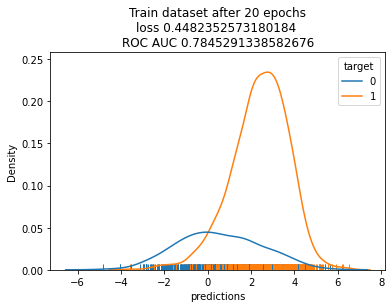

In [25]:
evaluate_model(trainer, training_dataloader, label='Train')

As you can see, the model is still having difficulties separating the classes.

### Predictions on the dev set

batch:   0%|          | 0/7 [00:00<?, ?it/s]

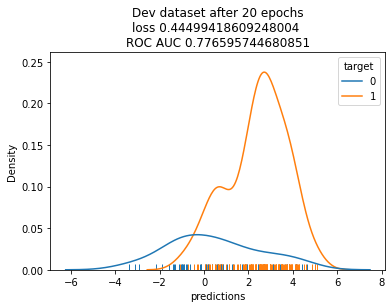

In [26]:
evaluate_model(trainer, dev_dataloader, label='Dev')

Performance on the dev set looks quite similar, so we're unlikely to be overfitting just yet

### Predictions on the test set
Here's how you can evaluate the model on the test set once you are done developing it

batch:   0%|          | 0/7 [00:00<?, ?it/s]

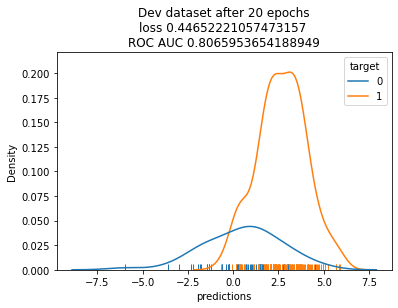

In [27]:
evaluate_model(trainer, test_dataloader, label='Dev')

# Task

We've trained a Graph Neural Network using a single set of hyper parameters.Experiment with different hyper parameters and see how good you can make the predictions. You can find the hyper parameters in the cell above looking like this

```
config = BasicGNNConfig(d_model=32, n_layers=4, residual_connections=True, 
                        ffn_dim=32, 
                        prediction_head_dim=32,
                        layer_norm=True, 
                        dropout_rate=0.2,
                        graph_pooling='sum')
```

What settings do you need to overfit and can you find a sweet stop where you don't?

d_model: means the number of layers

residual_connections : bypassing some layers 
prevents oversmoothing (which is caused by connection of all nodes to each other)

ffn_dimention: feed forward network dimention 

graph_pooling : can consist of max, mean or sum 

